In [1]:
import scipy.io

# Load the mat file
mat = scipy.io.loadmat(r"D:\Glaucoma\unet\ORIGA\ORIGA\OrigaList.mat")
origa = mat['Origa']

In [2]:
import os
import shutil

# Define source and destination paths
src_folder = r"D:\Glaucoma\unet\ORIGA\ORIGA\Images"
dst_folder = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\raw_images"

# Create destination folder if it doesn't exist
os.makedirs(dst_folder, exist_ok=True)

# Loop through files in the source folder
for filename in os.listdir(src_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, filename)
        shutil.move(src_path, dst_path)
        print(f"Moved: {filename}")

print("✅ All images moved successfully.")


Moved: 001.jpg
Moved: 002.jpg
Moved: 003.jpg
Moved: 004.jpg
Moved: 005.jpg
Moved: 006.jpg
Moved: 007.jpg
Moved: 008.jpg
Moved: 009.jpg
Moved: 010.jpg
Moved: 011.jpg
Moved: 012.jpg
Moved: 013.jpg
Moved: 014.jpg
Moved: 015.jpg
Moved: 016.jpg
Moved: 017.jpg
Moved: 018.jpg
Moved: 019.jpg
Moved: 020.jpg
Moved: 021.jpg
Moved: 022.jpg
Moved: 023.jpg
Moved: 024.jpg
Moved: 025.jpg
Moved: 026.jpg
Moved: 027.jpg
Moved: 028.jpg
Moved: 029.jpg
Moved: 030.jpg
Moved: 031.jpg
Moved: 032.jpg
Moved: 033.jpg
Moved: 034.jpg
Moved: 035.jpg
Moved: 036.jpg
Moved: 037.jpg
Moved: 038.jpg
Moved: 039.jpg
Moved: 040.jpg
Moved: 041.jpg
Moved: 042.jpg
Moved: 043.jpg
Moved: 044.jpg
Moved: 045.jpg
Moved: 046.jpg
Moved: 047.jpg
Moved: 048.jpg
Moved: 049.jpg
Moved: 050.jpg
Moved: 051.jpg
Moved: 052.jpg
Moved: 053.jpg
Moved: 054.jpg
Moved: 055.jpg
Moved: 056.jpg
Moved: 057.jpg
Moved: 058.jpg
Moved: 059.jpg
Moved: 060.jpg
Moved: 061.jpg
Moved: 062.jpg
Moved: 063.jpg
Moved: 064.jpg
Moved: 065.jpg
Moved: 066.jpg
Moved: 067

In [3]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def extract_optic_disc_roi_enhanced(src_path, dst_path, roi_size=256):
    img = cv2.imread(src_path)

    if img is None:
        print(f"❌ Failed to read: {src_path}")
        return

    # Resize to standard size for consistent processing
    img_resized = cv2.resize(img, (512, 512))

    # Extract red channel
    red_channel = img_resized[:, :, 2]

    # Apply CLAHE to enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    red_enhanced = clahe.apply(red_channel)

    # Blur and threshold
    blurred = cv2.GaussianBlur(red_enhanced, (11, 11), 0)
    _, thresh = cv2.threshold(blurred, 220, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print(f"⚠️ No optic disc detected in {src_path}")
        return

    # Select largest contour (likely optic disc)
    largest_contour = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    x, y, r = int(x), int(y), int(radius)

    # Calculate ROI coordinates
    x1 = max(x - roi_size // 2, 0)
    y1 = max(y - roi_size // 2, 0)
    x2 = x1 + roi_size
    y2 = y1 + roi_size

    # Crop and save
    roi = img_resized[y1:y2, x1:x2]
    if roi.shape[0] != roi_size or roi.shape[1] != roi_size:
        print(f"⚠️ Skipped due to incorrect crop size: {src_path}")
        return

    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    cv2.imwrite(dst_path, roi)

In [4]:
RAW_PATH = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\raw_images"
DST_PATH = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\roi_images"

image_files = sorted([f for f in os.listdir(RAW_PATH) if f.endswith('.jpg')])

for filename in tqdm(image_files):
    src_path = os.path.join(RAW_PATH, filename)
    dst_path = os.path.join(DST_PATH, filename)
    extract_optic_disc_roi_enhanced(src_path, dst_path)

 34%|███▍      | 220/650 [00:26<00:46,  9.17it/s]

⚠️ Skipped due to incorrect crop size: D:\Glaucoma\unet\ORIGA\ORIGA\data\raw_images\218.jpg


 49%|████▉     | 319/650 [00:46<00:40,  8.13it/s]

⚠️ Skipped due to incorrect crop size: D:\Glaucoma\unet\ORIGA\ORIGA\data\raw_images\317.jpg


 78%|███████▊  | 509/650 [01:07<00:13, 10.70it/s]

⚠️ Skipped due to incorrect crop size: D:\Glaucoma\unet\ORIGA\ORIGA\data\raw_images\508.jpg


100%|██████████| 650/650 [01:23<00:00,  7.77it/s]


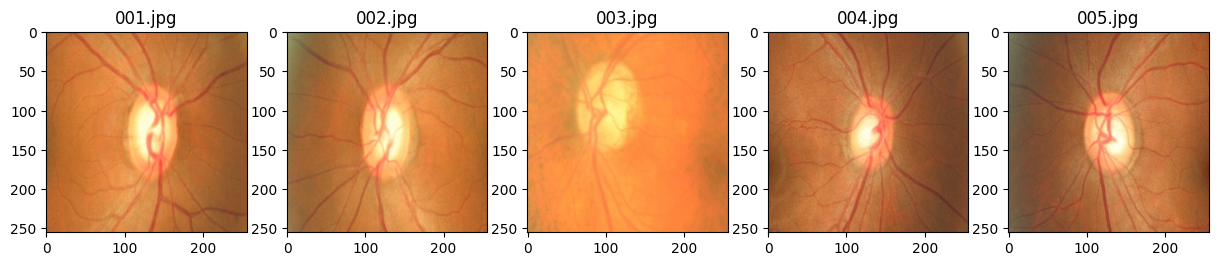

In [5]:
import matplotlib.pyplot as plt

roi_images = sorted([f for f in os.listdir(DST_PATH) if f.endswith('.jpg')])
plt.figure(figsize=(15, 5))
for i in range(5):
    roi_path = os.path.join(DST_PATH, roi_images[i])
    roi_img = cv2.imread(roi_path)
    roi_rgb = cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(roi_rgb)
    plt.title(roi_images[i])
    plt.axis('on')
plt.show()


In [6]:
#MASKING CUP AND DISC

In [8]:
import os

# Define paths
cup_folder = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup"
disc_folder = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\disc"

def delete_png_images(folder_path):
    deleted = 0
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".png"):
            file_path = os.path.join(folder_path, filename)
            os.remove(file_path)
            deleted += 1
            print(f"Deleted: {file_path}")
    if deleted == 0:
        print(f"No .png images found in {folder_path}")
    else:
        print(f"✅ Deleted {deleted} .png images from {folder_path}")

# Run for both folders
delete_png_images(cup_folder)
delete_png_images(disc_folder)


Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\001.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\002.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\003.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\004.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\005.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\006.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\007.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\008.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\009.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\010.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\011.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\012.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\013.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\014.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\015.png
Deleted: D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup\016.png
Deleted: D:\Glaucoma\une

Unique values in mask: [0 1 2]


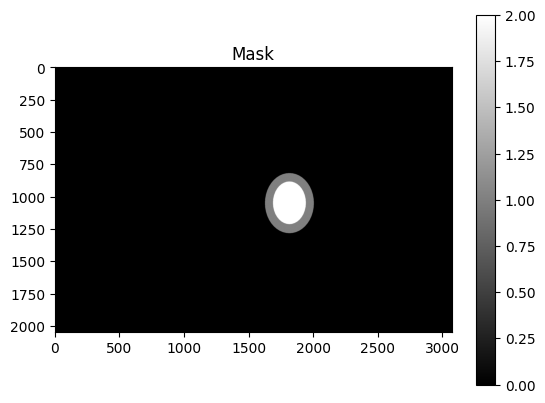

In [10]:
import scipy.io
import matplotlib.pyplot as plt

# Load one .mat file
mat = scipy.io.loadmat(r"D:\Glaucoma\unet\ORIGA\ORIGA\Semi-automatic-annotations\001.mat")
mask = mat["mask"]

# Show unique values
print("Unique values in mask:", np.unique(mask))

# Plot the mask
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.colorbar()
plt.show()


In [9]:
import scipy.io
import numpy as np
from PIL import Image
import os

mat_dir = r"D:\Glaucoma\unet\ORIGA\ORIGA\Semi-automatic-annotations"  # put your .mat files here
output_disc = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\disc"
output_cup = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup"

for mat_file in os.listdir(mat_dir):
    if mat_file.endswith(".mat"):
        mat = scipy.io.loadmat(os.path.join(mat_dir, mat_file))
        mask = mat['mask']  # replace with actual variable name if different

        # Split masks
        disc_mask = (mask == 1).astype(np.uint8) * 255
        cup_mask = (mask == 2).astype(np.uint8) * 255

        base_name = mat_file.replace('.mat', '.png')
        Image.fromarray(disc_mask).save(os.path.join(output_disc, base_name))
        Image.fromarray(cup_mask).save(os.path.join(output_cup, base_name))

print("✅ Disc and cup masks created.")


✅ Disc and cup masks created.


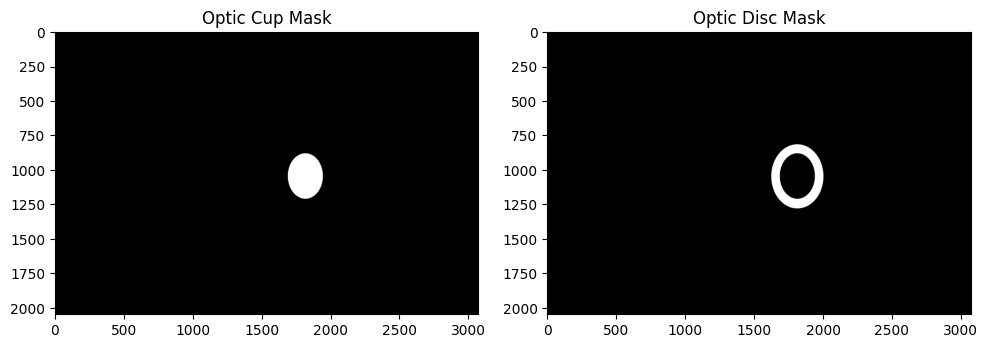

In [13]:
import matplotlib.pyplot as plt
import cv2
import os

# Pick one sample
sample = '001.png'

# Correct local paths
cup_path = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup"
disc_path = r"D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\disc"

# Read the images using the full path
cup = cv2.imread(os.path.join(cup_path, sample), cv2.IMREAD_GRAYSCALE)
disc = cv2.imread(os.path.join(disc_path, sample), cv2.IMREAD_GRAYSCALE)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Optic Cup Mask')
plt.imshow(cup, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Optic Disc Mask')
plt.imshow(disc, cmap='gray')

plt.tight_layout()
plt.show()


In [15]:
#DATA PREPARARION

In [16]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def resize_and_save(src_folder, dst_folder, size=(256, 256)):
    os.makedirs(dst_folder, exist_ok=True)
    for filename in tqdm(os.listdir(src_folder)):
        if filename.endswith(('.png', '.jpg')):
            img_path = os.path.join(src_folder, filename)
            img = Image.open(img_path).resize(size)
            img.save(os.path.join(dst_folder, filename))

# Resize raw images
resize_and_save(r'D:\Glaucoma\unet\ORIGA\ORIGA\data\raw_images', r'D:\Glaucoma\unet\ORIGA\ORIGA\data\segmentation_data\images')

# Resize cup masks
resize_and_save(r'D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\cup', r'D:\Glaucoma\unet\ORIGA\ORIGA\data\segmentation_data\masks\cup')

# Resize disc masks
resize_and_save(r'D:\Glaucoma\unet\ORIGA\ORIGA\data\masks\disc', r'D:\Glaucoma\unet\ORIGA\ORIGA\data\segmentation_data\masks\disc')


100%|██████████| 650/650 [00:35<00:00, 18.56it/s]


In [1]:
import torch
print(torch.__version__)


2.7.0+cpu


In [3]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.upconv3(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.out(d1))


In [5]:
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

class FundusSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.image_filenames[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.mask_filenames[idx])).convert("L")

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

transform = transforms.Compose([
    transforms.ToTensor(),
])

cup_dataset = FundusSegmentationDataset(
    r'D:\Glaucoma\unet\ORIGA\ORIGA\data\segmentation_data\images',
    r'D:\Glaucoma\unet\ORIGA\ORIGA\data\segmentation_data\masks\cup',
    transform=transform
)

cup_loader = DataLoader(cup_dataset, batch_size=8, shuffle=True)


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, masks in cup_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(cup_loader):.4f}")


In [ ]:
torch.save(model.state_dict(), "unet_cup_segmentation.pth")


In [ ]:
model.eval()
with torch.no_grad():
    sample_img, _ = cup_dataset[0]
    sample_img = sample_img.unsqueeze(0).to(device)
    pred_mask = model(sample_img).squeeze().cpu().numpy()

import matplotlib.pyplot as plt
plt.imshow(pred_mask > 0.5, cmap='gray')
plt.title("Predicted Cup Mask")
plt.axis('on')
plt.show()


FOR DISC 

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

class FundusSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.image_filenames[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.mask_filenames[idx])).convert("L")

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

#  Replace cup mask dir with disc mask dir
disc_dataset = FundusSegmentationDataset(
    r'D:\Glaucoma\unet\ORIGA\ORIGA\data\segmentation_data\images',
    r'D:\Glaucoma\unet\ORIGA\ORIGA\data\segmentation_data\masks\disc',
    transform=transform
)

disc_loader = DataLoader(disc_dataset, batch_size=8, shuffle=True)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)  # Use the same U-Net architecture
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, masks in disc_loader:  # 👈 Use disc_loader instead of cup_loader
        imgs, masks = imgs.to(device), masks.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(disc_loader):.4f}")


In [ ]:
torch.save(model.state_dict(), "unet_cup_segmentation.pth")

In [ ]:
model.eval()
with torch.no_grad():
    sample_img, _ = disc_dataset[0]
    sample_img = sample_img.unsqueeze(0).to(device)
    pred_mask = model(sample_img).squeeze().cpu().numpy()

import matplotlib.pyplot as plt
plt.imshow(pred_mask > 0.5, cmap='gray')
plt.title("Predicted Disc Mask")
plt.axis('on')
plt.show()